# Covariates Backtest Analysis (Returns target)

This notebook analyzes the **covariate ablation backtests** on the *returns* dataset across a **context length sweep**:
- `context_length ∈ {128, 256, 512}`
- horizons: `H ∈ {1, 5, 20}`
- variants:
  - `baseline` (target only)
  - `past_only` (past technical covariates)
  - `calendar_only` (calendar covariates)
  - `past_plus_known_future` (technical + known-future calendar)

Metrics:
- **MAE** computed on the median forecast (0.5 quantile)
- **Mean pinball loss** across quantiles (0.1, 0.5, 0.9)

We focus on **paired comparisons** against the baseline, aligned by `(cutoff, horizon, context_length)` so the deltas are directly comparable.


In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Resolve project root robustly
CWD = Path.cwd()
PROJECT_ROOT = CWD.parent if CWD.name == "notebooks" else CWD
sys.path.append(str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

DATA_DIR = PROJECT_ROOT / "data" / "processed"


PROJECT_ROOT: /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension


## Load backtest results (context sweep)

Expected files (generated by `src/backtest/backtest_covariates.py` and then renamed):
- `data/processed/e1_backtest_ctx128.parquet`
- `data/processed/e1_backtest_ctx256.parquet`
- `data/processed/e1_backtest_ctx512.parquet`


In [2]:
paths = {
    128: DATA_DIR / "e1_backtest_ctx128.parquet",
    256: DATA_DIR / "e1_backtest_ctx256.parquet",
    512: DATA_DIR / "e1_backtest_ctx512.parquet",
}

for ctx, p in paths.items():
    print(ctx, "->", p, "| exists:", p.exists())

missing = [str(p) for p in paths.values() if not p.exists()]
if missing:
    raise FileNotFoundError(
        "Missing one or more expected parquet files:\n"
        + "\n".join(missing)
        + "\n\nTip: run backtest script and rename outputs into these filenames."
    )

dfs = []
for ctx, p in paths.items():
    d = pd.read_parquet(p)
    d["context_length"] = ctx
    d["cutoff"] = pd.to_datetime(d["cutoff"])
    dfs.append(d)

res = pd.concat(dfs, ignore_index=True)

print("Shape:", res.shape)
print("Columns:", res.columns.tolist())
display(res.head())


128 -> /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension/data/processed/e1_backtest_ctx128.parquet | exists: True
256 -> /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension/data/processed/e1_backtest_ctx256.parquet | exists: True
512 -> /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension/data/processed/e1_backtest_ctx512.parquet | exists: True
Shape: (2136, 7)
Columns: ['cutoff', 'horizon', 'variant', 'mae', 'pinball', 'n_points', 'context_length']


,cutoff,horizon,variant,mae,pinball,n_points,context_length
0,2024-10-09,1,baseline,0.009509,0.003225,61,128
1,2024-10-09,1,past_only,0.009078,0.003086,61,128
2,2024-10-09,1,past_plus_known_future,0.009217,0.003084,61,128
3,2024-10-09,1,calendar_only,0.009072,0.003061,61,128
4,2024-10-16,1,baseline,0.007520,0.002797,61,128


## Quick sanity checks

We verify:
- expected variants / horizons exist
- roughly consistent number of windows per group
- metrics have no NaNs


In [3]:
print("NaN rates:")
display(res[["mae", "pinball"]].isna().mean())

print("\nUnique horizons:", sorted(res["horizon"].unique().tolist()))
print("Unique variants:", sorted(res["variant"].unique().tolist()))
print("Unique ctx:", sorted(res["context_length"].unique().tolist()))

counts = (
    res.groupby(["context_length", "horizon", "variant"])
       .size()
       .rename("n_windows")
       .reset_index()
       .sort_values(["context_length", "horizon", "variant"])
)
display(counts.head(24))


NaN rates:


mae        0.0
pinball    0.0
dtype: float64


Unique horizons: [1, 5, 20]
Unique variants: ['baseline', 'calendar_only', 'past_only', 'past_plus_known_future']
Unique ctx: [128, 256, 512]


,context_length,horizon,variant,n_windows
0,128,1,baseline,56
1,128,1,calendar_only,56
2,128,1,past_only,56
3,128,1,past_plus_known_future,56
4,128,5,baseline,60
5,128,5,calendar_only,60
6,128,5,past_only,60
7,128,5,past_plus_known_future,60
8,128,20,baseline,60
9,128,20,calendar_only,60


## Summary tables (mean MAE / mean pinball)

These are descriptive aggregates across cutoffs.


In [4]:
summary = (
    res.groupby(["context_length", "horizon", "variant"], as_index=False)
       .agg(
           mae_mean=("mae", "mean"),
           pinball_mean=("pinball", "mean"),
           n=("mae", "size"),
       )
)

summary_sorted = summary.sort_values(["context_length", "horizon", "mae_mean"])
display(summary_sorted)

mae_pivot = summary.pivot_table(
    index=["context_length", "horizon"], columns="variant", values="mae_mean"
).sort_index()

pin_pivot = summary.pivot_table(
    index=["context_length", "horizon"], columns="variant", values="pinball_mean"
).sort_index()

print("MAE (mean):")
display(mae_pivot)
print("\nPinball (mean):")
display(pin_pivot)


,context_length,horizon,variant,mae_mean,pinball_mean,n
0,128,1,baseline,0.014845,0.005114,56
2,128,1,past_only,0.014894,0.005125,56
1,128,1,calendar_only,0.014908,0.005133,56
3,128,1,past_plus_known_future,0.014966,0.005146,56
4,128,5,baseline,0.014149,0.004810,60
6,128,5,past_only,0.014203,0.004825,60
5,128,5,calendar_only,0.014214,0.004806,60
7,128,5,past_plus_known_future,0.014233,0.004809,60
8,128,20,baseline,0.014128,0.004838,60
10,128,20,past_only,0.014159,0.004840,60


MAE (mean):


variant                 baseline  calendar_only  past_only  \
context_length horizon                                       
128            1        0.014845       0.014908   0.014894   
               5        0.014149       0.014214   0.014203   
               20       0.014128       0.014175   0.014159   
256            1        0.013063       0.013059   0.013121   
               5        0.014021       0.014006   0.014068   
               20       0.014058       0.014056   0.014074   
512            1        0.015195       0.015127   0.015202   
               5        0.013969       0.013947   0.013975   
               20       0.014010       0.013998   0.014004   

variant                 past_plus_known_future  
context_length horizon                          
128            1                      0.014966  
               5                      0.014233  
               20                     0.014172  
256            1                      0.013117  
               5                      0.014066  
               20                     0.014077  
512            1                      0.015179  
               5                      0.013978  
               20                     0.014003


Pinball (mean):


variant                 baseline  calendar_only  past_only  \
context_length horizon                                       
128            1        0.005114       0.005133   0.005125   
               5        0.004810       0.004806   0.004825   
               20       0.004838       0.004817   0.004840   
256            1        0.004332       0.004316   0.004345   
               5        0.004750       0.004735   0.004755   
               20       0.004774       0.004763   0.004776   
512            1        0.005248       0.005209   0.005224   
               5        0.004728       0.004713   0.004717   
               20       0.004764       0.004749   0.004752   

variant                 past_plus_known_future  
context_length horizon                          
128            1                      0.005146  
               5                      0.004809  
               20                     0.004818  
256            1                      0.004335  
               5                      0.004747  
               20                     0.004764  
512            1                      0.005225  
               5                      0.004719  
               20                     0.004744

## Paired deltas vs baseline (per cutoff)

We compute **delta = metric(variant) − metric(baseline)** after aligning by:
`(context_length, horizon, cutoff)`.

Interpretation:
- **negative delta** → variant improves over baseline (lower is better)
- **positive delta** → variant is worse than baseline


In [5]:
def add_deltas(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    base = (
        df[df["variant"] == "baseline"][["context_length", "horizon", "cutoff", metric]]
        .rename(columns={metric: f"{metric}_baseline"})
    )
    out = df.merge(base, on=["context_length", "horizon", "cutoff"], how="inner")
    out[f"delta_{metric}"] = out[metric] - out[f"{metric}_baseline"]
    return out

res_d = add_deltas(res.copy(), "mae")
res_d = add_deltas(res_d, "pinball")

# Keep only non-baseline variants for delta analysis
res_d = res_d[res_d["variant"] != "baseline"].copy()

display(res_d[["context_length", "horizon", "variant", "cutoff", "delta_mae", "delta_pinball"]].head())


,context_length,horizon,variant,cutoff,delta_mae,delta_pinball
1,128,1,past_only,2024-10-09,-0.000431,-0.000139
2,128,1,past_plus_known_future,2024-10-09,-0.000293,-0.000141
3,128,1,calendar_only,2024-10-09,-0.000437,-0.000164
5,128,1,past_only,2024-10-16,-0.000180,-0.000116
6,128,1,past_plus_known_future,2024-10-16,-0.000094,-0.000126


## Paired bootstrap confidence intervals (mean delta)

For each `(context_length, horizon, variant)` we bootstrap the mean of `delta_metric`
over cutoffs to estimate a 95% CI.


In [6]:
def bootstrap_mean_ci(x: np.ndarray, n_boot: int = 5000, alpha: float = 0.05, seed: int = 0):
    rng = np.random.default_rng(seed)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return np.nan, (np.nan, np.nan), 0
    boots = rng.choice(x, size=(n_boot, len(x)), replace=True).mean(axis=1)
    lo = np.quantile(boots, alpha / 2)
    hi = np.quantile(boots, 1 - alpha / 2)
    return float(np.mean(x)), (float(lo), float(hi)), int(len(x))

rows = []
for (ctx, H, var), g in res_d.groupby(["context_length", "horizon", "variant"]):
    m_mae, (lo_mae, hi_mae), n_mae = bootstrap_mean_ci(g["delta_mae"].values, seed=1)
    m_pin, (lo_pin, hi_pin), n_pin = bootstrap_mean_ci(g["delta_pinball"].values, seed=2)
    rows.append(
        {
            "context_length": ctx,
            "horizon": H,
            "variant": var,
            "delta_mae_mean": m_mae,
            "delta_mae_ci_low": lo_mae,
            "delta_mae_ci_high": hi_mae,
            "delta_pin_mean": m_pin,
            "delta_pin_ci_low": lo_pin,
            "delta_pin_ci_high": hi_pin,
            "n_windows": len(g),
        }
    )

ci_df = pd.DataFrame(rows).sort_values(["context_length", "horizon", "delta_mae_mean"])
display(ci_df)


,context_length,horizon,variant,delta_mae_mean,delta_mae_ci_low,delta_mae_ci_high,delta_pin_mean,delta_pin_ci_low,delta_pin_ci_high,n_windows
1,128,1,past_only,0.000049,-7.399992e-05,0.000178,1.137833e-05,-0.000027,5.280314e-05,56
0,128,1,calendar_only,0.000063,-8.580139e-05,0.000247,1.898278e-05,-0.000033,7.810329e-05,56
2,128,1,past_plus_known_future,0.000121,-4.740008e-05,0.000320,3.267125e-05,-0.000022,9.230310e-05,56
4,128,5,past_only,0.000054,3.994706e-06,0.000100,1.517823e-05,-0.000006,3.546089e-05,60
3,128,5,calendar_only,0.000065,-1.509385e-05,0.000158,-3.865563e-06,-0.000034,2.791306e-05,60
5,128,5,past_plus_known_future,0.000084,2.013710e-06,0.000171,-4.887853e-07,-0.000031,3.118260e-05,60
7,128,20,past_only,0.000032,1.178547e-05,0.000052,1.807119e-06,-0.000011,1.388449e-05,60
8,128,20,past_plus_known_future,0.000045,1.353735e-05,0.000079,-1.991156e-05,-0.000043,2.193240e-06,60
6,128,20,calendar_only,0.000047,9.214313e-06,0.000087,-2.146964e-05,-0.000047,3.064272e-06,60
9,256,1,calendar_only,-0.000004,-9.211845e-05,0.000087,-1.564265e-05,-0.000046,1.297902e-05,60


## Distribution view: boxplots of deltas

These plots show the **distribution over cutoffs** for each `(horizon, variant)` and are useful to
see variability and outliers.

Note: we use `tick_labels=` (Matplotlib ≥ 3.9) to avoid deprecation warnings.


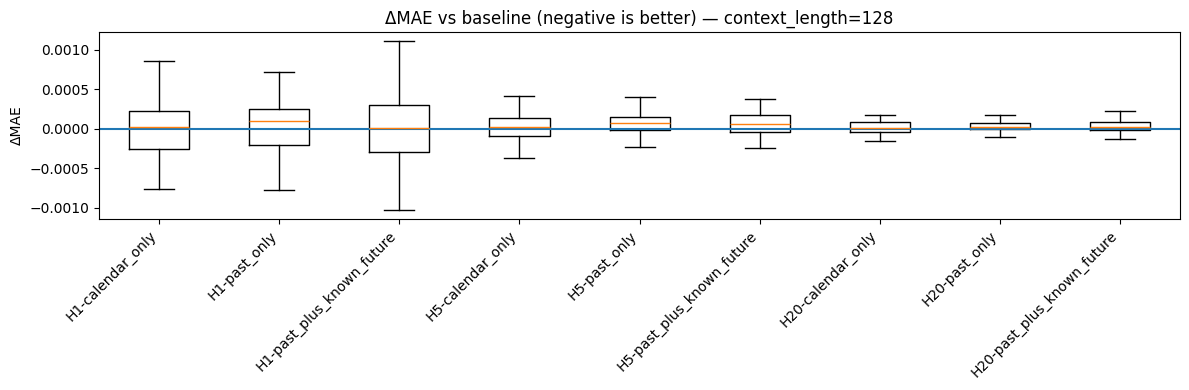

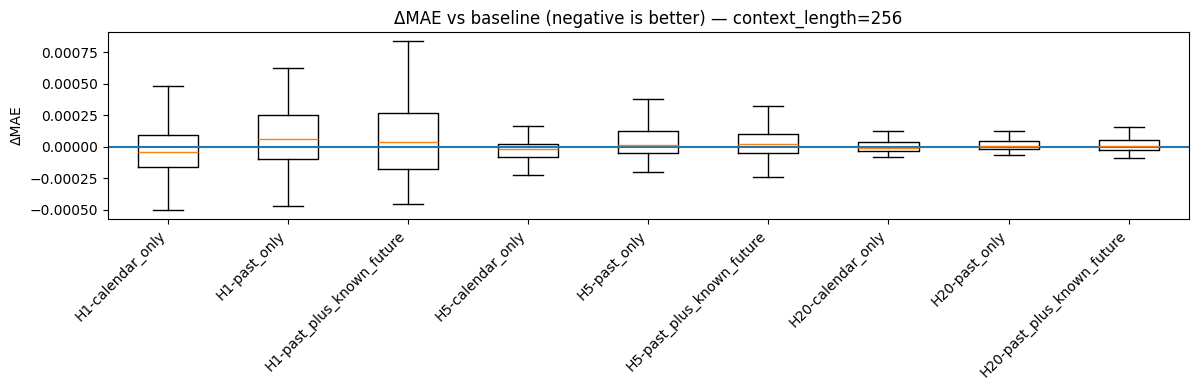

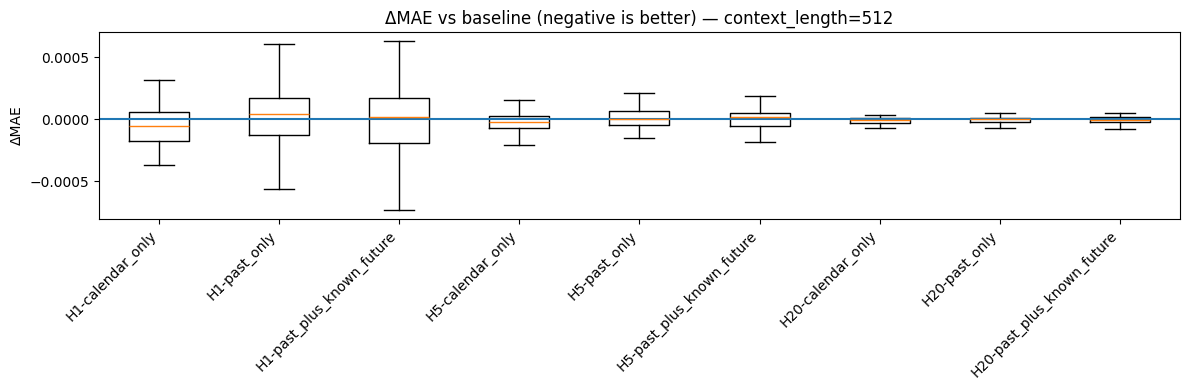

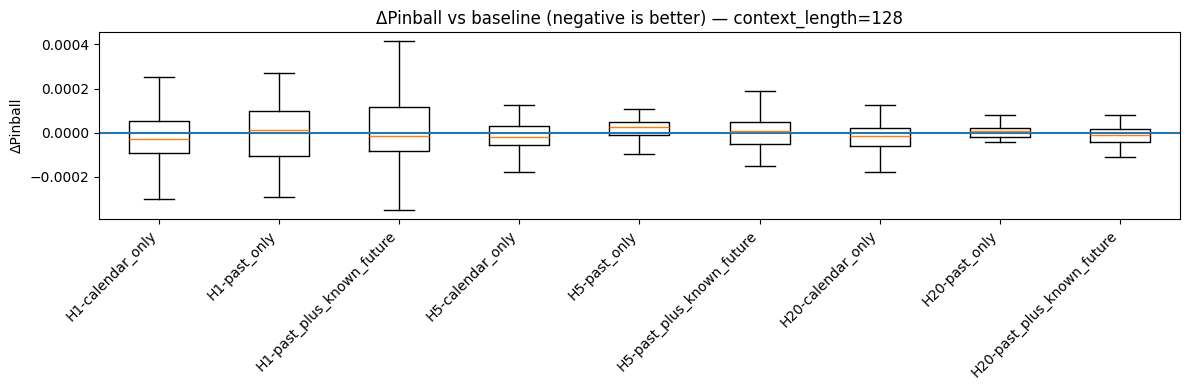

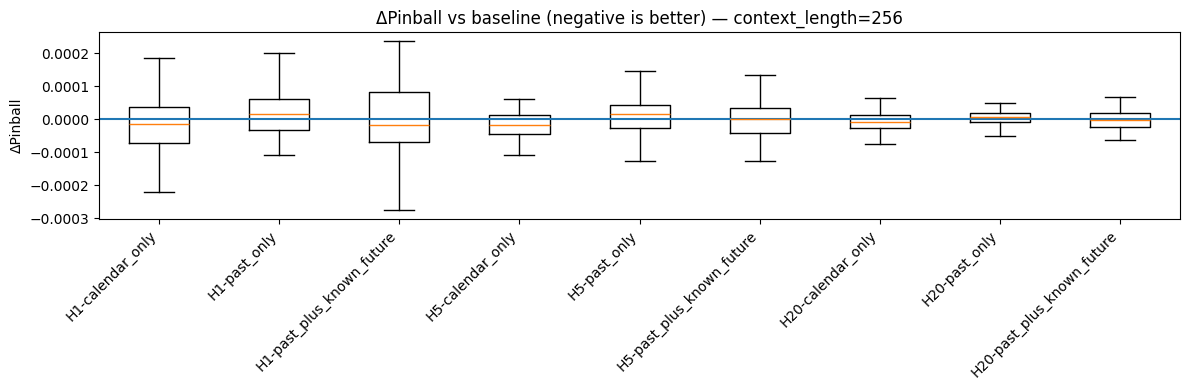

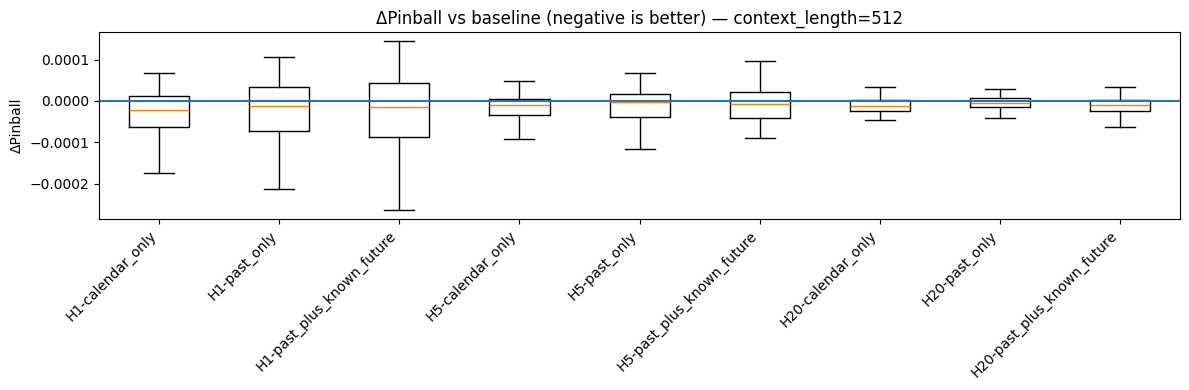

In [7]:
def plot_delta_boxplots(metric: str, ylabel: str):
    for ctx in sorted(res_d["context_length"].unique()):
        g = res_d[res_d["context_length"] == ctx]
        horizons = sorted(g["horizon"].unique())
        variants = sorted(g["variant"].unique())

        data, labels = [], []
        for H in horizons:
            for var in variants:
                vals = g[(g["horizon"] == H) & (g["variant"] == var)][metric].values
                data.append(vals)
                labels.append(f"H{H}-{var}")

        plt.figure(figsize=(12, 4))
        plt.boxplot(data, tick_labels=labels, showfliers=False)
        plt.axhline(0.0)
        plt.title(f"{ylabel} vs baseline (negative is better) — context_length={ctx}")
        plt.xticks(rotation=45, ha="right")
        plt.ylabel(ylabel)
        plt.tight_layout()
        plt.show()

plot_delta_boxplots("delta_mae", "ΔMAE")
plot_delta_boxplots("delta_pinball", "ΔPinball")


## Heatmap of mean deltas (compact overview)

A small "heatmap-like" matrix per context length summarizing mean deltas.


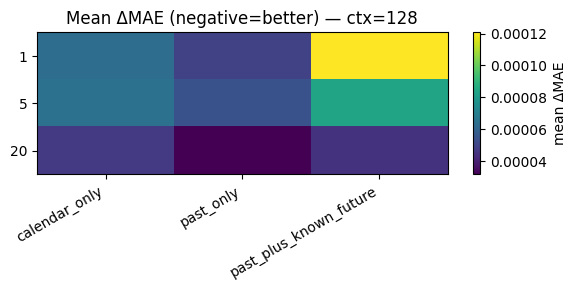

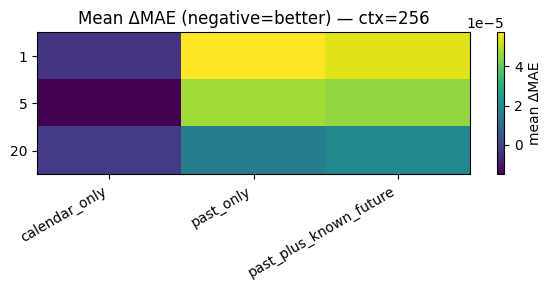

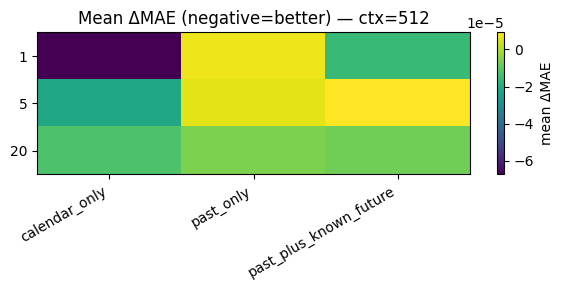

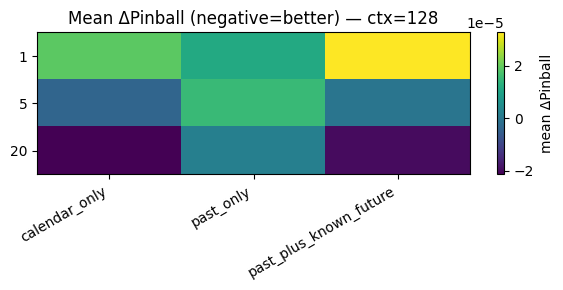

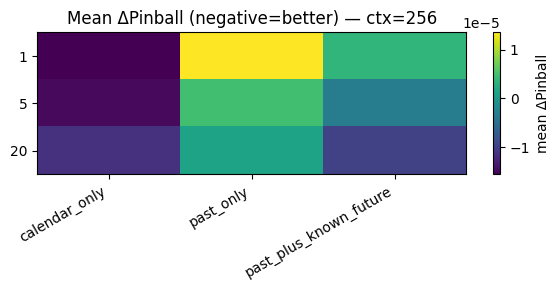

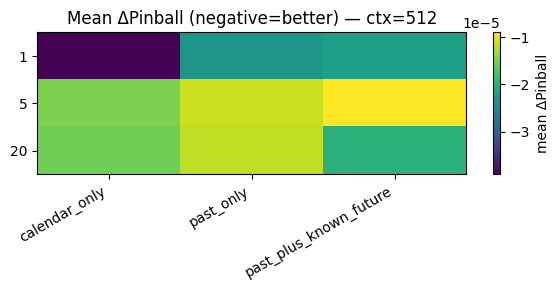

In [8]:
def heatmap_mean_deltas(value_col: str, title: str, cbar_label: str):
    tmp = ci_df.copy()
    for ctx in sorted(tmp["context_length"].unique()):
        g = tmp[tmp["context_length"] == ctx].pivot(index="horizon", columns="variant", values=value_col)
        plt.figure(figsize=(6, 3))
        plt.imshow(g.values, aspect="auto")
        plt.xticks(range(g.shape[1]), g.columns, rotation=30, ha="right")
        plt.yticks(range(g.shape[0]), g.index)
        plt.colorbar(label=cbar_label)
        plt.title(f"{title} — ctx={ctx}")
        plt.tight_layout()
        plt.show()

heatmap_mean_deltas("delta_mae_mean", "Mean ΔMAE (negative=better)", "mean ΔMAE")
heatmap_mean_deltas("delta_pin_mean", "Mean ΔPinball (negative=better)", "mean ΔPinball")


## Forest plot: mean ΔMAE with 95% CI

This is a presentation-friendly visualization: each point is a mean delta and the bar is its 95% CI.


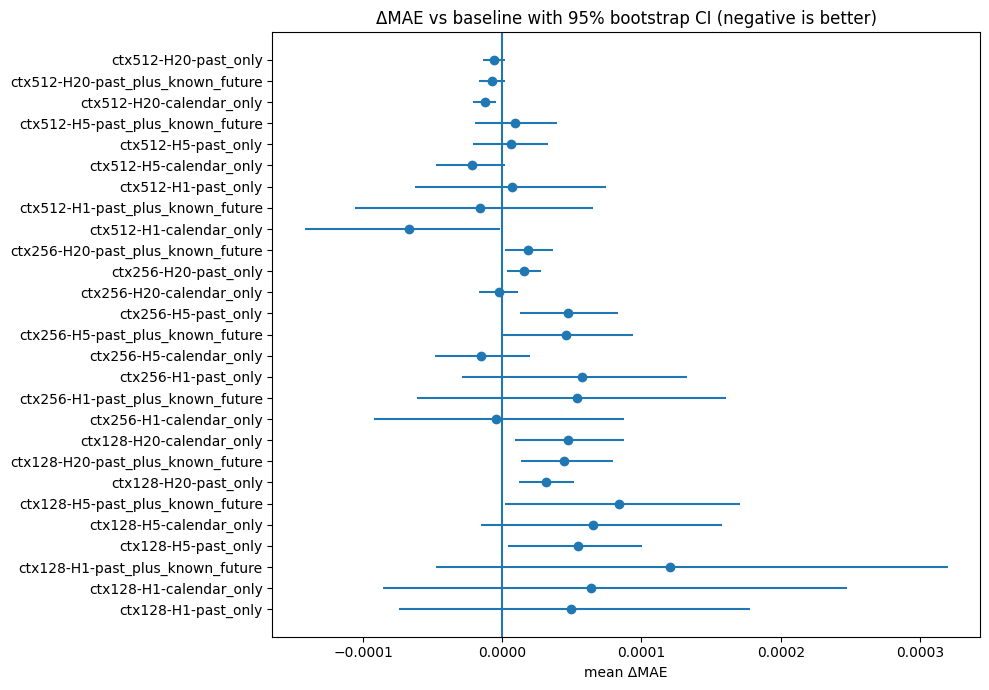

In [9]:
val, lo, hi = "delta_mae_mean", "delta_mae_ci_low", "delta_mae_ci_high"
plot_df = ci_df.sort_values(["context_length", "horizon", val]).reset_index(drop=True)

plt.figure(figsize=(10, 7))
y = np.arange(len(plot_df))
xerr = np.vstack([plot_df[val] - plot_df[lo], plot_df[hi] - plot_df[val]])
plt.errorbar(plot_df[val], y, xerr=xerr, fmt="o")
plt.axvline(0.0)
plt.yticks(
    y,
    plot_df.apply(lambda r: f"ctx{int(r.context_length)}-H{int(r.horizon)}-{r.variant}", axis=1),
)
plt.title("ΔMAE vs baseline with 95% bootstrap CI (negative is better)")
plt.xlabel("mean ΔMAE")
plt.tight_layout()
plt.show()


## Win-rate: how often each variant beats baseline

Win-rate is the fraction of cutoffs where `delta_metric < 0`.


In [10]:
win = (
    res_d.assign(
        win_mae=(res_d["delta_mae"] < 0).astype(int),
        win_pin=(res_d["delta_pinball"] < 0).astype(int),
    )
    .groupby(["context_length", "horizon", "variant"], as_index=False)
    .agg(
        winrate_mae=("win_mae", "mean"),
        winrate_pin=("win_pin", "mean"),
        n=("win_mae", "size"),
    )
)

display(
    win.sort_values(["context_length", "horizon", "winrate_mae"], ascending=[True, True, False]).head(24)
)


,context_length,horizon,variant,winrate_mae,winrate_pin,n
2,128,1,past_plus_known_future,0.482143,0.535714,56
0,128,1,calendar_only,0.446429,0.553571,56
1,128,1,past_only,0.446429,0.428571,56
3,128,5,calendar_only,0.400000,0.633333,60
5,128,5,past_plus_known_future,0.350000,0.433333,60
4,128,5,past_only,0.300000,0.316667,60
6,128,20,calendar_only,0.416667,0.666667,60
8,128,20,past_plus_known_future,0.383333,0.583333,60
7,128,20,past_only,0.283333,0.400000,60
9,256,1,calendar_only,0.566667,0.566667,60


## Key takeaways (to copy into a report)

- Covariate gains are **small** (as expected for financial series), but can be **systematic** depending on context length.
- **Calendar-only** tends to be the most robust covariate family across horizons.
- Technical covariates (`past_only`) show limited and inconsistent gains for returns in this setup.
- The paired analysis reduces confounding: deltas are computed on the *same cutoffs* for baseline and variant.


## Export tables

We save the summary aggregates and bootstrap CI table for inclusion in a report.


In [11]:
out_dir = DATA_DIR
out_dir.mkdir(parents=True, exist_ok=True)

(summary.sort_values(["context_length", "horizon", "variant"])
        .to_csv(out_dir / "e1_summary_mean_metrics.csv", index=False))
(ci_df.to_csv(out_dir / "e1_bootstrap_ci.csv", index=False))

print("Saved:", out_dir / "e1_summary_mean_metrics.csv")
print("Saved:", out_dir / "e1_bootstrap_ci.csv")


Saved: /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension/data/processed/e1_summary_mean_metrics.csv
Saved: /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension/data/processed/e1_bootstrap_ci.csv
